# Import library

In [50]:
import pandas as pd
import requests
!pip3 install geocoder
import geocoder
!pip3 install folium
import folium
!pip3 install beautifulsoup4
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
!pip3 install seaborn 
import seaborn as sns

## Import Data

In [7]:
data_2015 = pd.read_csv('./data/crime-incident-reports-2015.csv')
data_2016 = pd.read_csv('./data/crime-incident-reports-2016.csv')
data_2017 = pd.read_csv('./data/crime-incident-reports-2017.csv')
data_2018 = pd.read_csv('./data/crime-incident-reports-2018.csv')
data_2019 = pd.read_csv('./data/crime-incident-reports-2019.csv')
data_2020 = pd.read_csv('./data/crime-incident-reports-2020.csv')

C:\Users\jeffe\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Checking their shape and total row count

In [22]:
print('2015: ',data_2015.shape)
print('2016: ',data_2016.shape)
print('2017: ',data_2017.shape)
print('2018: ',data_2018.shape)
print('2019: ',data_2019.shape)
print('2020: ',data_2020.shape)
total_row = data_2015.shape[0] + data_2016.shape[0] + data_2017.shape[0] + data_2018.shape[0] + data_2019.shape[0] + data_2020.shape[0] 
print(total_row)

2015:  (53597, 17)
2016:  (99430, 17)
2017:  (101338, 17)
2018:  (98888, 17)
2019:  (19782, 17)
2020:  (70894, 17)
443929


## Concat all 5 years data into one dataframe

In [25]:
data = pd.concat([data_2015,data_2016,data_2017,data_2018,data_2019,data_2020])
data.shape

(443929, 17)

In [84]:
data.head(5)

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,I192068249,2647,Other,THREATS TO DO BODILY HARM,B2,280,NaN,2015-08-28 10:20:00,2015,8,Friday,10,Part Two,WASHINGTON ST,42.330119,-71.084251,"(42.33011862, -71.08425106)"
1,I192061894,1106,Confidence Games,FRAUD - CREDIT CARD / ATM FRAUD,C11,356,NaN,2015-08-20 00:00:00,2015,8,Thursday,0,Part Two,CHARLES ST,42.300605,-71.061268,"(42.30060543, -71.06126785)"
2,I192038828,1107,Fraud,FRAUD - IMPERSONATION,A1,172,NaN,2015-11-02 12:24:00,2015,11,Monday,12,Part Two,ALBANY ST,42.334288,-71.072395,"(42.33428841, -71.07239518)"
3,I192008877,1107,Fraud,FRAUD - IMPERSONATION,E18,525,NaN,2015-07-31 10:00:00,2015,7,Friday,10,Part Two,WINGATE RD,42.237009,-71.129566,"(42.23700950, -71.12956606)"
4,I182090828,1102,Fraud,FRAUD - FALSE PRETENSE / SCHEME,D4,159,NaN,2015-12-01 12:00:00,2015,12,Tuesday,12,Part Two,UPTON ST,42.342432,-71.072258,"(42.34243222, -71.07225766)"


## Visualizing crime count by District and different Categeory

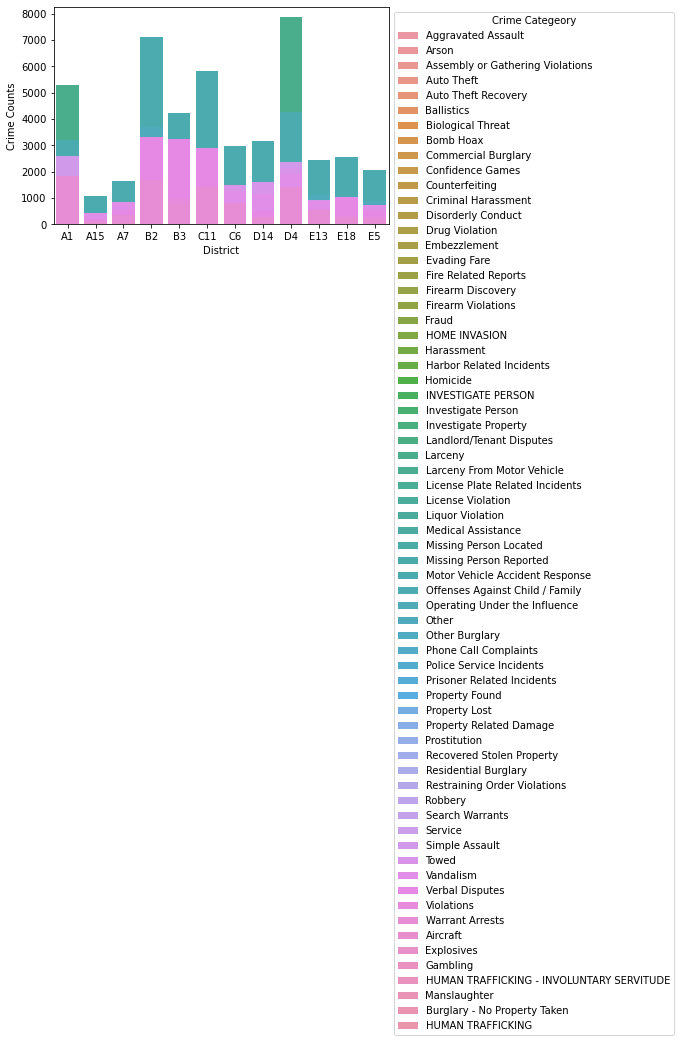

In [83]:
dis = data.groupby(by=["DISTRICT","OFFENSE_CODE_GROUP"]).size()
s = dis.to_frame()
s = s.reset_index()
s.columns = ["District","Crime_cat","Crime Counts"]
ax = sns.barplot(x ="District", y = 'Crime Counts', data = s, hue = "Crime_cat" , dodge=False)
plt.legend(title = 'Crime Categeory', bbox_to_anchor = (1, 1))

In [26]:
data['DISTRICT'].unique()

array(['B2', 'C11', 'A1', 'E18', 'D4', 'B3', nan, 'C6', 'D14', 'A7', 'E5',
       'E13', 'A15', 'External'], dtype=object)

In [9]:
CLIENT_ID = 'AQ4P5KPELSSWLOEVTEC0ET4FNEVSJJATZC1NUQ13YFMY11W1' # your Foursquare ID
CLIENT_SECRET = 'BMGVJICF0ZI0OAXWYEQRAU3DD4S503UH3VEG0BCKAWKIOWMF' # your Foursquare Secret
ACCESS_TOKEN = '1JVCUVC4B0EDL4JMLOSQ2INS35E3R2VYMEWS55U4UZW0FBMV' # your FourSquare Access Token
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: AQ4P5KPELSSWLOEVTEC0ET4FNEVSJJATZC1NUQ13YFMY11W1
CLIENT_SECRET:BMGVJICF0ZI0OAXWYEQRAU3DD4S503UH3VEG0BCKAWKIOWMF


In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [13]:
PostalCode = data['DISTRICT'].unique()
latitude=[]
longitude=[]
for i in range (len(PostalCode)):
    g = geocoder.arcgis('{}, Boston, MA'.format(PostalCode[i]))
    lat_lng_coords = g.latlng
    latitude.append(lat_lng_coords[0]) 
    longitude.append(lat_lng_coords[1]) 

In [19]:
g = geocoder.arcgis('East Boston, Boston, MA')
lat_lng_coords = g.latlng
lat_lng_coords

[42.35141817326235, -71.05671435784329]

In [22]:
g = geocoder.arcgis('ROXBURY, Boston, MA')
lat_lng_coords = g.latlng
lat_lng_coords
latitude=lat_lng_coords[0]
longitude=lat_lng_coords[1]

In [29]:
van_map = folium.Map(location=[latitude, longitude], zoom_start=13)
folium.CircleMarker(
        [latitude, longitude],
        radius=3,
        popup='ROXBURY, Boston, MA',
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(van_map) 

In [30]:
van_map

In [2]:
import json
import urllib.request
url = 'https://data.boston.gov/api/3/action/datastore_search?resource_id=792031bf-b9bb-467c-b118-fe795befdf00'  
fileobj = urllib.request.urlopen(url)
response_dict = json.loads(fileobj.read())
print(response_dict)

{'help': 'https://data.boston.gov/api/3/action/help_show?name=datastore_search', 'success': True, 'result': {'include_total': True, 'resource_id': '792031bf-b9bb-467c-b118-fe795befdf00', 'fields': [{'type': 'int', 'id': '_id'}, {'type': 'text', 'id': 'INCIDENT_NUMBER'}, {'type': 'text', 'id': 'OFFENSE_CODE'}, {'type': 'text', 'id': 'OFFENSE_CODE_GROUP'}, {'type': 'text', 'id': 'OFFENSE_DESCRIPTION'}, {'type': 'text', 'id': 'DISTRICT'}, {'type': 'text', 'id': 'REPORTING_AREA'}, {'type': 'text', 'id': 'SHOOTING'}, {'type': 'text', 'id': 'OCCURRED_ON_DATE'}, {'type': 'text', 'id': 'YEAR'}, {'type': 'text', 'id': 'MONTH'}, {'type': 'text', 'id': 'DAY_OF_WEEK'}, {'type': 'text', 'id': 'HOUR'}, {'type': 'text', 'id': 'UCR_PART'}, {'type': 'text', 'id': 'STREET'}, {'type': 'text', 'id': 'Lat'}, {'type': 'text', 'id': 'Long'}, {'type': 'text', 'id': 'Location'}], 'records_format': 'objects', 'records': [{'STREET': 'WASHINGTON ST', 'OFFENSE_DESCRIPTION': 'THREATS TO DO BODILY HARM', 'SHOOTING':

In [6]:
pd1 = pd.DataFrame()

AttributeError: module 'pandas' has no attribute 'from_dict'